### 🔑 Authenticate & Download Data


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d phucthaiv02/butterfly-image-classification
!unzip -o butterfly-image-classification.zip -d /content/butterfly_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/butterfly_data/train/Image_2348.jpg  
  inflating: /content/butterfly_data/train/Image_2349.jpg  
  inflating: /content/butterfly_data/train/Image_235.jpg  
  inflating: /content/butterfly_data/train/Image_2350.jpg  
  inflating: /content/butterfly_data/train/Image_2351.jpg  
  inflating: /content/butterfly_data/train/Image_2352.jpg  
  inflating: /content/butterfly_data/train/Image_2353.jpg  
  inflating: /content/butterfly_data/train/Image_2354.jpg  
  inflating: /content/butterfly_data/train/Image_2355.jpg  
  inflating: /content/butterfly_data/train/Image_2356.jpg  
  inflating: /content/butterfly_data/train/Image_2357.jpg  
  inflating: /content/butterfly_data/train/Image_2358.jpg  
  inflating: /content/butterfly_data/train/Image_2359.jpg  
  inflating: /content/butterfly_data/train/Image_236.jpg  
  inflating: /content/butterfly_data/train/Image_2360.jpg  
  inflating: /content/butterfly_data/train/Image_23

## 🏗️ Building & Evaluating the Logistic Regression Model


Top 10 most frequent classes: ['MOURNING CLOAK', 'SLEEPY ORANGE', 'ATALA', 'BROWN SIPROETA', 'SCARCE SWALLOW', 'CRECENT', 'BANDED ORANGE HELICONIAN', 'MILBERTS TORTOISESHELL', 'RED CRACKER', 'ORANGE TIP']
PCA reduced feature dimensions from 150528 to 200


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



— Validation Set Metrics —
Accuracy: 0.6525
Precision (weighted): 0.6588
Recall (weighted): 0.6525
F1 Score (weighted): 0.6421

Classification Report (Validation Set):
                          precision    recall  f1-score   support

          MOURNING CLOAK       0.67      0.74      0.71        39
           SLEEPY ORANGE       0.67      0.94      0.78        32
                   ATALA       0.52      0.73      0.61        30
          BROWN SIPROETA       0.67      0.33      0.44        30
          SCARCE SWALLOW       0.84      0.72      0.78        29
                 CRECENT       0.76      0.55      0.64        29
BANDED ORANGE HELICONIAN       0.66      0.66      0.66        29
  MILBERTS TORTOISESHELL       0.48      0.55      0.52        29
             RED CRACKER       0.50      0.34      0.41        29
              ORANGE TIP       0.81      0.90      0.85        29

                accuracy                           0.65       305
               macro avg       0.66  

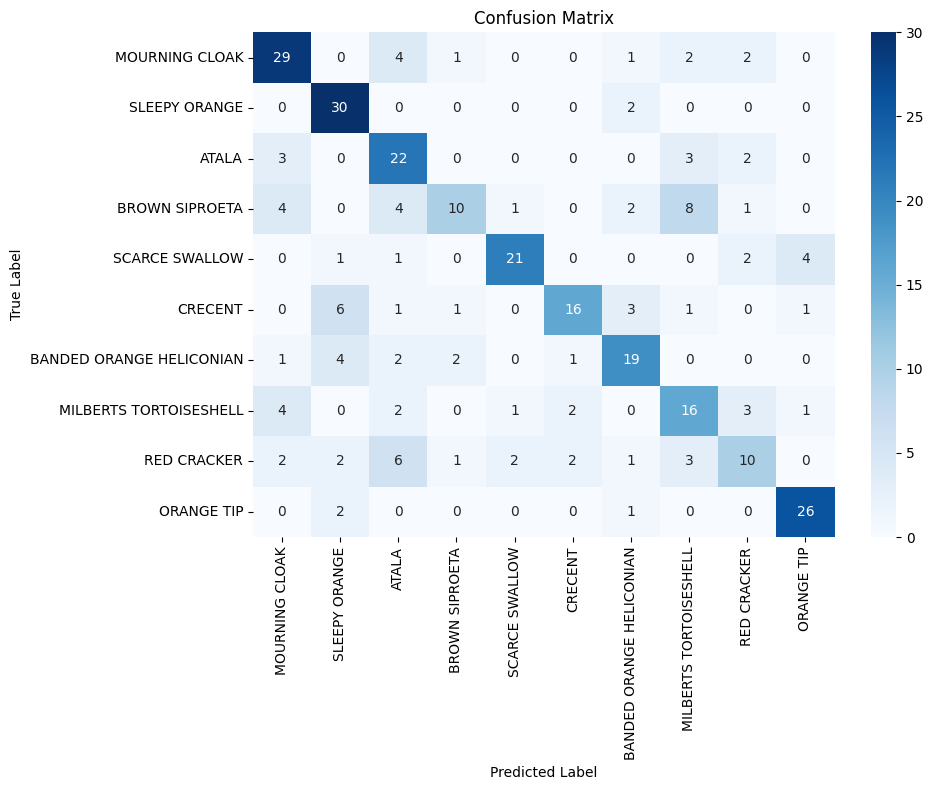


— Final Test Predictions —
      filename predicted_label
0  Image_1.jpg  SCARCE SWALLOW
1  Image_2.jpg     RED CRACKER
2  Image_3.jpg  SCARCE SWALLOW
3  Image_4.jpg           ATALA
4  Image_5.jpg   SLEEPY ORANGE


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. Paths
TRAIN_DIR = '/content/butterfly_data/train'
TEST_DIR = '/content/butterfly_data/test'
TRAIN_CSV = '/content/butterfly_data/Training_set.csv'
TEST_CSV = '/content/butterfly_data/Testing_set.csv'

# 2. Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df.columns = train_df.columns.str.strip().str.lower()
test_df.columns = test_df.columns.str.strip().str.lower()

if 'filename' not in train_df.columns or 'label' not in train_df.columns:
    raise ValueError("Training CSV must contain 'filename' and 'label' columns.")

# 3. Filter top 10 classes
top_classes = train_df['label'].value_counts().head(10).index.tolist()
print("Top 10 most frequent classes:", top_classes)
train_df = train_df[train_df['label'].isin(top_classes)].reset_index(drop=True)

# 4. Load and preprocess images
def load_images(df, folder, classes, size=(224, 224)):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        try:
            img = load_img(img_path, target_size=size)
            arr = img_to_array(img) / 255.0
            X.append(arr.flatten())  # 224*224*3 = 150528
            y.append(classes.index(row['label']))
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(X), np.array(y)

# Training set
X_train, y_train = load_images(train_df, TRAIN_DIR, top_classes)

# 5. Train-test split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)

# 6. Scale the data before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_test_scaled = scaler.transform(X_test_split)

# 7. Apply PCA
pca = PCA(n_components=200)  # or n_components=0.95 for 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA reduced feature dimensions from {X_train.shape[1]} to {X_train_pca.shape[1]}")

# 8. Train Logistic Regression on PCA-reduced data
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_pca, y_train_split)

# 9. Predict
y_pred_split = logreg.predict(X_test_pca)

# 10. Metrics
acc = accuracy_score(y_test_split, y_pred_split)
prec = precision_score(y_test_split, y_pred_split, average='weighted', zero_division=0)
rec = recall_score(y_test_split, y_pred_split, average='weighted', zero_division=0)
f1 = f1_score(y_test_split, y_pred_split, average='weighted', zero_division=0)

print(f"\n— Validation Set Metrics —")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# 11. Classification Report
print("\nClassification Report (Validation Set):")
print(classification_report(y_test_split, y_pred_split, target_names=top_classes))

# 12. Confusion Matrix
cm = confusion_matrix(y_test_split, y_pred_split)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_classes, yticklabels=top_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 13. Process test images and predict final test labels
def load_test_images(df, folder, size=(224, 224)):
    X = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        try:
            img = load_img(img_path, target_size=size)
            arr = img_to_array(img) / 255.0
            X.append(arr.flatten())
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(X)

X_final_test = load_test_images(test_df, TEST_DIR)

# Standardize and apply PCA to test data
X_final_test_scaled = scaler.transform(X_final_test)
X_final_test_pca = pca.transform(X_final_test_scaled)

# Final predictions
y_pred_final_test = logreg.predict(X_final_test_pca)
test_df['predicted_label'] = [top_classes[i] for i in y_pred_final_test]
test_df.to_csv('/content/test_with_predictions.csv', index=False)

print("\n— Final Test Predictions —")
print(test_df[['filename', 'predicted_label']].head())
